In [74]:
#Data from https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/data
#Data size is relatively small
#Train with more data for better results.
#Might contain bugs that need to be reviewed.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
!pip install rdkit

In [76]:
cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


In [77]:
import numpy as np
import pandas as pd
import keras
import sys
import tensorflow as tf

In [78]:
df = pd.read_parquet("de_train.parquet")

In [79]:
df.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [80]:
smiles=df['SMILES']

In [81]:
df = df.drop(['sm_name', 'sm_lincs_id','control', 'SMILES'], axis=1)

In [82]:
df.head()

,cell_type,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [83]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_imputer = SimpleImputer(strategy='mean')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')

        # Define column names
        self.categorical_column = 'cell_type'
        self.label_encoder = LabelEncoder()
        self.fitted = False

    def fit(self, X, y=None):
        X = X.copy()

        # Separate columns
        self.numerical_columns = [col for col in X.columns if col != self.categorical_column]

        # Fit imputer and scaler on numerical columns
        self.num_imputer.fit(X[self.numerical_columns])
        X_num_imputed = self.num_imputer.transform(X[self.numerical_columns])
        self.scaler.fit(X_num_imputed)

        # Fit imputer and label encoder on cell_type
        self.cat_imputer.fit(X[[self.categorical_column]])
        cell_type_imputed = self.cat_imputer.transform(X[[self.categorical_column]]).ravel()
        self.label_encoder.fit(cell_type_imputed)

        self.fitted = True
        return self

    def transform(self, X):
        if not self.fitted:
            raise RuntimeError("You must fit the preprocessor before calling transform.")

        X = X.copy()

        # Impute and scale numerical columns
        X_num_imputed = self.num_imputer.transform(X[self.numerical_columns])
        X_num_scaled = self.scaler.transform(X_num_imputed)

        # Impute and encode categorical column
        cell_type_imputed = self.cat_imputer.transform(X[[self.categorical_column]]).ravel()
        cell_type_encoded = self.label_encoder.transform(cell_type_imputed).reshape(-1, 1)

        # Combine and return
        X_processed = np.hstack([cell_type_encoded, X_num_scaled])
        return X_processed

In [84]:
#Preprocess
preprocessor = CustomPreprocessor()
X_transformed = preprocessor.fit_transform(df)

In [85]:
print(X_transformed.shape)

(614, 18212)


In [86]:
#Numerical features
num_num = len(preprocessor.numerical_columns)

In [87]:
cat_dim = len(preprocessor.label_encoder.classes_)
print("Categorical feature and label-encoded class count:")
print(f"  cell_type: {cat_dim} unique labels")

print("Total features after transform:", 1 + len(preprocessor.numerical_columns))

Categorical feature and label-encoded class count:
  cell_type: 6 unique labels
Total features after transform: 18212


In [88]:
cat_dims = [len(preprocessor.label_encoder.classes_)]  # only 'cell_type'
num_num = len(preprocessor.numerical_columns)          # numeric gene columns

print("Categorical feature and label-encoded class count:")
print(f"  cell_type: {cat_dims[0]} unique labels")

print("Total numerical features:", num_num)
print("Total features after transform:", 1 + num_num)  # 1 for 'cell_type'

Categorical feature and label-encoded class count:
  cell_type: 6 unique labels
Total numerical features: 18211
Total features after transform: 18212


In [17]:
smiles=np.array(smiles)

In [18]:
print(smiles.shape)

(614,)


In [19]:
print(X_transformed.shape)

(614, 18212)


In [89]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize_smiles(smiles_list):
    # 1. Extract unique characters from SMILES strings
    charset = sorted(set("".join(smiles_list)))

    # 2. Create mapping from char → index (1-based indexing; 0 = padding)
    char_to_idx = {char: i + 1 for i, char in enumerate(charset)}
    idx_to_char = {i + 1: char for i, char in enumerate(charset)}

    # 3. Tokenize each SMILES into a list of indices
    encoded = [[char_to_idx[char] for char in smile] for smile in smiles_list]

    # 4. Pad sequences to the same length
    max_length = max(len(seq) for seq in encoded)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post', value=0)

    return np.array(padded), char_to_idx, idx_to_char, max_length

# === Tokenize your SMILES strings ===
smiles_encoded, char_to_idx, idx_to_char, max_smiles_length = tokenize_smiles(smiles)

In [90]:
#Generative MMD Autoencoder

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model, Input

# === Encoder ===
def build_encoder(input_dim, latent_dim, noise_stddev=0.1, dropout_rate=0.2, l2_reg=1e-4):
    inputs = Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.GaussianNoise(noise_stddev)(x)
    z = layers.Dense(latent_dim, name='latent_vector')(x)
    return Model(inputs, z, name="encoder")

# === Decoder ===
def build_decoder(latent_dim, vocab_size, max_length, embed_dim=64, l2_reg=1e-4):
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    x = layers.Dense(max_length * embed_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(latent_inputs)
    x = layers.Reshape((max_length, embed_dim))(x)
    x = layers.Masking(mask_value=0.0)(x)  # <<< Add masking here to ignore padded timesteps
    x = layers.GRU(128, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg))(x)
    outputs = layers.TimeDistributed(layers.Dense(vocab_size + 1, activation='softmax'))(x)
    return Model(latent_inputs, outputs, name="decoder")

# === MMD Loss ===
def mmd_loss(z, prior_z, sigma=1.0):
    def gaussian_kernel(x, y, sigma):
        x_norm = tf.reduce_sum(tf.square(x), axis=1, keepdims=True)
        y_norm = tf.reduce_sum(tf.square(y), axis=1, keepdims=True)
        dist = x_norm - 2 * tf.matmul(x, tf.transpose(y)) + tf.transpose(y_norm)
        return tf.exp(-dist / (2.0 * sigma ** 2))

    k_xx = gaussian_kernel(z, z, sigma)
    k_yy = gaussian_kernel(prior_z, prior_z, sigma)
    k_xy = gaussian_kernel(z, prior_z, sigma)

    return tf.reduce_mean(k_xx) + tf.reduce_mean(k_yy) - 2 * tf.reduce_mean(k_xy)

In [97]:
#Optionally add gradient-clipping
@tf.function
def train_step(batch_x, batch_smiles, lambda_mmd=10.0):
    with tf.GradientTape() as tape:
        z = encoder(batch_x, training=True)
        prior_z = tf.random.normal(shape=tf.shape(z))
        decoded = decoder(z, training=True)
        recon_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(batch_smiles, decoded, from_logits=False))
        mmd = mmd_loss(z, prior_z)
        total_loss = recon_loss + lambda_mmd * mmd

    grads = tape.gradient(total_loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
    return recon_loss, mmd, total_loss

# Set params
latent_dim = 32
batch_size = 64
epochs = 700
lambda_mmd = 1.0
input_dim = X_transformed.shape[1]
vocab_size = len(char_to_idx)
max_length = smiles_encoded.shape[1]

# Build models
encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, vocab_size, max_length)
optimizer = tf.keras.optimizers.Adam(1e-4)

# Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_transformed.astype(np.float32), smiles_encoded.astype(np.int32)))
dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Training loop
for epoch in range(epochs):
    recon_losses, mmd_losses, total_losses = [], [], []
    for batch_x, batch_smiles in dataset:
        recon, mmd, total = train_step(batch_x, batch_smiles, lambda_mmd)
        recon_losses.append(recon.numpy())
        mmd_losses.append(mmd.numpy())
        total_losses.append(total.numpy())
    print(f"Epoch {epoch+1}/{epochs} | Recon: {np.mean(recon_losses):.4f} | MMD: {np.mean(mmd_losses):.4f} | Total: {np.mean(total_losses):.4f}")

Epoch 1/700 | Recon: 3.4841 | MMD: 0.0368 | Total: 3.5210
Epoch 2/700 | Recon: 3.2349 | MMD: 0.0335 | Total: 3.2685
Epoch 3/700 | Recon: 2.5839 | MMD: 0.0334 | Total: 2.6173
Epoch 4/700 | Recon: 1.9820 | MMD: 0.0334 | Total: 2.0154
Epoch 5/700 | Recon: 1.7411 | MMD: 0.0334 | Total: 1.7745
Epoch 6/700 | Recon: 1.6168 | MMD: 0.0334 | Total: 1.6502
Epoch 7/700 | Recon: 1.5498 | MMD: 0.0334 | Total: 1.5832
Epoch 8/700 | Recon: 1.4987 | MMD: 0.0334 | Total: 1.5320
Epoch 9/700 | Recon: 1.4682 | MMD: 0.0334 | Total: 1.5016
Epoch 10/700 | Recon: 1.4426 | MMD: 0.0334 | Total: 1.4760
Epoch 11/700 | Recon: 1.4308 | MMD: 0.0334 | Total: 1.4642
Epoch 12/700 | Recon: 1.4299 | MMD: 0.0334 | Total: 1.4633
Epoch 13/700 | Recon: 1.4224 | MMD: 0.0334 | Total: 1.4557
Epoch 14/700 | Recon: 1.4147 | MMD: 0.0334 | Total: 1.4481
Epoch 15/700 | Recon: 1.4013 | MMD: 0.0334 | Total: 1.4347
Epoch 16/700 | Recon: 1.3991 | MMD: 0.0334 | Total: 1.4325
Epoch 17/700 | Recon: 1.3891 | MMD: 0.0334 | Total: 1.4226
Epoch 

In [98]:
import numpy as np

def generate_smiles(input_vector, encoder, decoder, idx_to_char, preprocessor=None,
                    num_samples=1, max_length=None, temperature=1.0):
    """
    Generate SMILES strings from a single input vector, with temperature sampling.

    Args:
        input_vector (np.ndarray or pd.Series or dict): raw or preprocessed input vector
        encoder (tf.keras.Model): trained encoder model
        decoder (tf.keras.Model): trained decoder model
        idx_to_char (dict): mapping from token index to character
        preprocessor (CustomPreprocessor, optional): preprocess input if provided
        num_samples (int): number of SMILES strings to generate
        max_length (int, optional): max length of output sequences
        temperature (float): softmax temperature (lower = conservative, higher = diverse)

    Returns:
        list of str: list of generated SMILES strings
    """
    # Preprocess if needed
    if preprocessor is not None:
        import pandas as pd
        if isinstance(input_vector, dict):
            input_vector = pd.DataFrame([input_vector])
        elif isinstance(input_vector, np.ndarray) and input_vector.ndim == 1:
            input_vector = pd.DataFrame([input_vector])
        elif isinstance(input_vector, pd.Series):
            input_vector = input_vector.to_frame().T
        input_vector = preprocessor.transform(input_vector)

    # Prepare input for encoder
    input_vector = np.array(input_vector, dtype=np.float32)
    if input_vector.ndim == 1:
        input_vector = np.expand_dims(input_vector, axis=0)

    # Encode to latent space
    z = encoder.predict(input_vector, verbose=0)

    # Decode sequence probabilities
    decoded_seq = decoder.predict(z, verbose=0)  # (1, max_length, vocab_size+1)
    if max_length is None:
        max_length = decoded_seq.shape[1]

    vocab_size_plus = decoded_seq.shape[2]

    samples = []
    for _ in range(num_samples):
        smiles_chars = []
        for t in range(max_length):
            logits = decoded_seq[0, t]  # shape: (vocab_size+1,)
            # Apply temperature
            logits = np.log(logits + 1e-9) / temperature
            probs = np.exp(logits) / np.sum(np.exp(logits))

            token_idx = np.random.choice(vocab_size_plus, p=probs)
            if token_idx == 0:  # Padding or stop
                break
            smiles_chars.append(idx_to_char.get(token_idx, ''))
        smiles = ''.join(smiles_chars)
        samples.append(smiles)

    return samples if num_samples > 1 else samples[0]

In [129]:
# Choose a temperature (e.g., 0.7 for conservative, 1.0 for standard, 1.5+ for diverse)
temperature = 1.5

# Set number of samples
num_samples = 120000

# Optionally add preprocessor if you're using raw input (like a dict or DataFrame row)
# Example with preprocessor:
# input_data = your_raw_input_dict_or_dataframe_row
# generated_smiles_list = generate_smiles(input_data, encoder, decoder, idx_to_char,
#                                         preprocessor=preprocessor,
#                                         num_samples=num_samples,
#                                         max_length=max_smiles_length,
#                                         temperature=temperature)

# If using already preprocessed input:
generated_smiles_list = generate_smiles(
    input_vector=X_transformed[0],
    encoder=encoder,
    decoder=decoder,
    idx_to_char=idx_to_char,
    num_samples=num_samples,
    max_length=max_smiles_length,
    temperature=temperature
)

In [130]:
from rdkit import Chem
from rdkit import RDLogger

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

def filter_valid_smiles(smiles_list):
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None and len(smi) >= 5:
            valid_smiles.append(smi)
    return valid_smiles

In [131]:
valid_smiles = filter_valid_smiles(set(generated_smiles_list))

In [132]:
print(len(valid_smiles))

312



**Molecule 1:** `Clc1ccccc1C(c1ccccc1)(c1ccncc1)n1cnnc1`  
- **logP:** 4.17  
- **MolWt:** 346.82  
- **TPSA:** 43.60  
- **QED:** 0.557  
- **SA Score:** 2.99  
- **SASA:** 381.35  


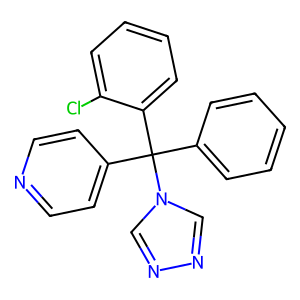


**Molecule 2:** `Clc1ccccc1C(c-c3ccc1)(c1ccccc1)n3ccnc1`  
- **logP:** 5.29  
- **MolWt:** 332.83  
- **TPSA:** 15.60  
- **QED:** 0.682  
- **SA Score:** 5.31  
- **SASA:** 403.28  


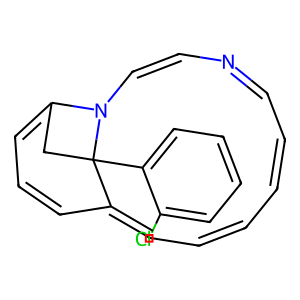


**Molecule 3:** `Clc1ccccccC(c1ccccc1)(ccccccc1)n1ccnc1`  
- **logP:** 6.10  
- **MolWt:** 372.90  
- **TPSA:** 17.82  
- **QED:** 0.582  
- **SA Score:** 4.81  
- **SASA:** 473.74  


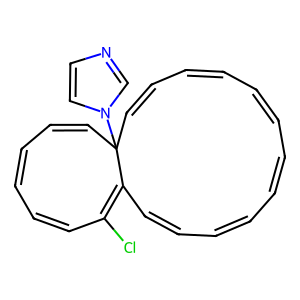


**Molecule 4:** `Clc1ccccc1C(c1ccccc1)1c(ccccc1)n1cccc1`  
- **logP:** 6.09  
- **MolWt:** 343.86  
- **TPSA:** 4.93  
- **QED:** 0.542  
- **SA Score:** 3.30  
- **SASA:** 402.59  


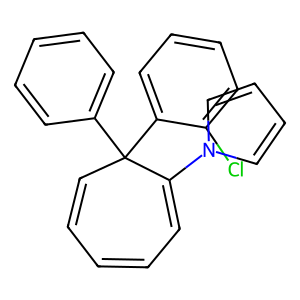


**Molecule 5:** `Clc1ccccc1C(n1cccc-1)(c1ccccc1)n1ccnc1`  
- **logP:** 4.64  
- **MolWt:** 333.82  
- **TPSA:** 22.75  
- **QED:** 0.533  
- **SA Score:** 3.18  
- **SASA:** 381.53  


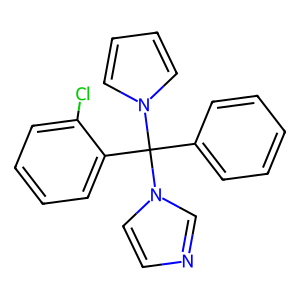


**Molecule 6:** `Clc1=cccc1C(c1ccccc1)(c1ncccc1)n1ccnc1`  
- **logP:** 4.29  
- **MolWt:** 331.81  
- **TPSA:** 30.71  
- **QED:** 0.668  
- **SA Score:** 3.80  
- **SASA:** 359.97  


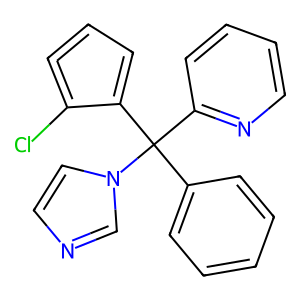


**Molecule 7:** `Clc1cccc11C(c1ccccc1)(c1ccccc1)ncccnc1`  
- **logP:** 5.18  
- **MolWt:** 344.85  
- **TPSA:** 24.72  
- **QED:** 0.578  
- **SA Score:** 6.25  
- **SASA:** 425.41  


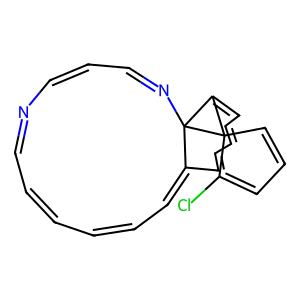


**Molecule 8:** `ClC1ccNcc1C(c1ccccc1)`  
- **logP:** 2.84  
- **MolWt:** 205.69  
- **TPSA:** 12.03  
- **QED:** 0.733  
- **SA Score:** 3.43  
- **SASA:** 260.34  


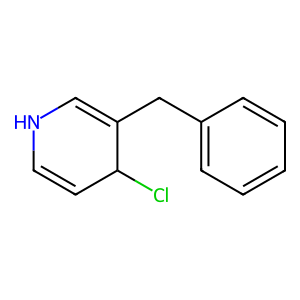


**Molecule 9:** `Clc1ccccc1C(c1cccc11)(cnccccc1)n1ccnc1`  
- **logP:** 4.86  
- **MolWt:** 345.83  
- **TPSA:** 30.18  
- **QED:** 0.764  
- **SA Score:** 4.54  
- **SASA:** 397.10  


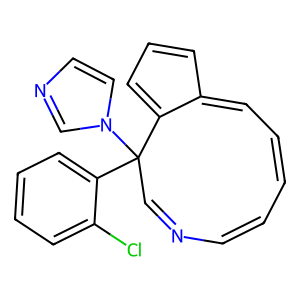


**Molecule 10:** `Clc1=ccc11C(c1ccccc1)(c1ccccc1)nnccnc1`  
- **logP:** 5.12  
- **MolWt:** 331.81  
- **TPSA:** 37.08  
- **QED:** 0.553  
- **SA Score:** 6.64  
- **SASA:** 373.28  


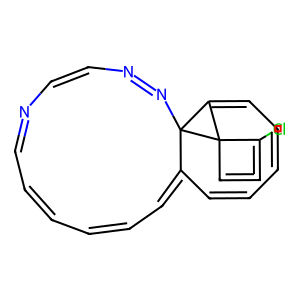

In [133]:
#Implement Lipinski-Rule of Five and show top-k molecules that pass filter along with properties.
import os
import sys
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, Crippen, QED, AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdFreeSASA import CalcSASA, classifyAtoms, SASAOpts
from rdkit.Chem import RDConfig
from IPython.display import display, Markdown

# Load sascorer from RDKit contrib
sascorer_path = os.path.join(RDConfig.RDContribDir, 'SA_Score')
if sascorer_path not in sys.path:
    sys.path.append(sascorer_path)

import sascorer

# Show top valid molecules with properties
top_k = 10
subset = valid_smiles[:top_k]

for i, smi in enumerate(subset):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"Invalid SMILES: {smi}")
        continue

    # Compute descriptors
    logp    = Crippen.MolLogP(mol)
    molwt   = Descriptors.MolWt(mol)
    qed     = QED.qed(mol)
    sa_score = sascorer.calculateScore(mol)
    tpsa    = rdMolDescriptors.CalcTPSA(mol)

    # Try to compute SASA (requires 3D structure)
    try:
        mol3d = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol3d, AllChem.ETKDG())
        radii = classifyAtoms(mol3d, SASAOpts())
        sasa  = CalcSASA(mol3d, radii)
    except Exception as e:
        sasa = None

    # Format values safely
    props = f"""
**Molecule {i+1}:** `{smi}`
- **logP:** {logp:.2f}
- **MolWt:** {molwt:.2f}
- **TPSA:** {tpsa:.2f}
- **QED:** {qed:.3f}
- **SA Score:** {sa_score:.2f}
- **SASA:** {sasa:.2f}
""" if sasa is not None else f"""
**Molecule {i+1}:** `{smi}`
- **logP:** {logp:.2f}
- **MolWt:** {molwt:.2f}
- **TPSA:** {tpsa:.2f}
- **QED:** {qed:.3f}
- **SA Score:** {sa_score:.2f}
- **SASA:** N/A
"""

    display(Markdown(props))
    display(Draw.MolToImage(mol, size=(300, 300)))

In [134]:
len(valid_smiles)

312

In [139]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import numpy as np

def plot_smiles_clusters(smiles_list, max_clusters=10):
    # Convert SMILES to Morgan fingerprints
    fps = []
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            fps.append(fp)
            valid_smiles.append(smi)

    if not fps:
        print("No valid molecules found.")
        return

    # Convert fingerprints to numpy array
    arr = np.array([np.array(list(fp.ToBitString()), dtype=int) for fp in fps])

    # Dimensionality reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca", learning_rate='auto')
    reduced = tsne.fit_transform(arr)

    # Find optimal number of clusters using GMM with BIC
    bic_scores = []
    models = []
    for n in range(2, max_clusters + 1):
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(reduced)
        bic = gmm.bic(reduced)
        bic_scores.append(bic)
        models.append(gmm)

    # Choose best model
    best_n = np.argmin(bic_scores) + 2  # +2 because range starts at 2
    best_gmm = models[best_n - 2]
    labels = best_gmm.predict(reduced)

    # Plot t-SNE with clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7, edgecolors='k')
    plt.title(f'GMM Clustering of Molecules (Optimal Clusters: {best_n})')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)
    plt.show()

    # Optional: return clustering info
    #return {
     #   "reduced_coords": reduced,
      #  "labels": labels,
       # "bic_scores": bic_scores,
       # "optimal_n": best_n,
       # "valid_smiles": valid_smiles
   # }

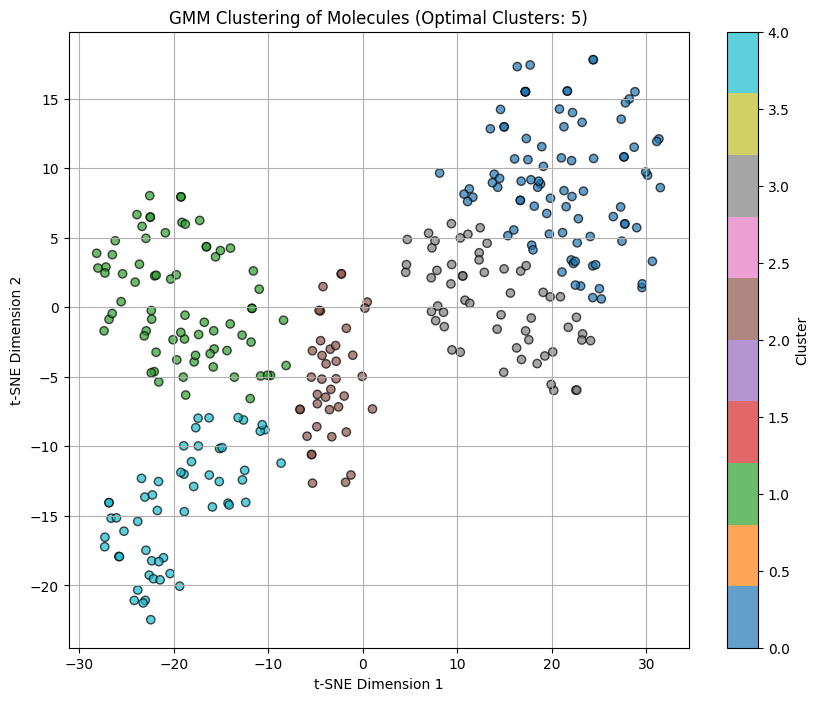

In [140]:
plot_smiles_clusters(valid_smiles, max_clusters=10)